# Projet n°10 : Detection de faux-billets 

## Table des matières
* [Données](#donnees)
    * [Corrélation des variables](#cor)
* [Régression linéaire](#reglin)
    * [Calcul des levier](#lev)
    * [Résidus studentisé](#res)
    * [Distance de cook](#cook)
    * [Test d'hypothèse](#hyp)
* [Application du modèle](#appli)
* [Régression logistique](#log)
    * [test d'hypothèse](#hyp2)
* [KMeans](#kmeans)
* [Conclusion](#con)

# Import des librairies necessaires

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import t, shapiro
from scipy.stats import levene
import scipy.stats as stats

import statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Donnée <a class="anchor" id="donnees"></a>

Le dataframe billets contient plusieurs informations :  

* **is genuine** : si oui ou non le billet est authentique  

* **diagonal** : la longueur de la diagonal en mm du billet  

* **height_left, height_right** : la hauteur (gauche ou droite) du billet en mm 

* **margin_low, margin_up** : la marge entre le bord (inférieur ou supérieur) du billet et l'image en mm  

* **length** : la longueur du billet en mm

In [2]:
dfp=pd.read_csv('billets.csv', sep=';')

In [3]:
dfp.info()
dfp.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [4]:
def doublons(df):
    print(len(df) - len(df.drop_duplicates()), 'doublons parfait')

doublons(dfp)

0 doublons parfait


In [5]:
dfp.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

In [6]:
# Encoder la variable is_genuine
dfp['is_genuine'].replace([False,True], [0,1], inplace=True)
dfp.head()
#Pour m'assurer que dans  la regression logistique de statsmodel, la prediction des billets soit vrai et non faux 

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54


Il nous manque des données pour margin_low. Une régréssion linéaire pourrait nous aider a combler ce manque et donc ne pas perdre d'information.

<AxesSubplot:ylabel='margin_low'>

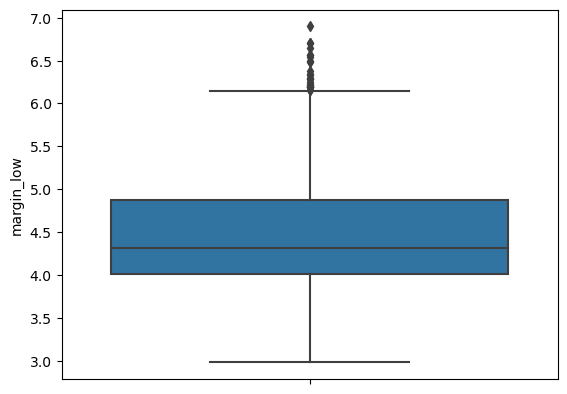

In [7]:
sns.boxplot(data=dfp,y='margin_low')

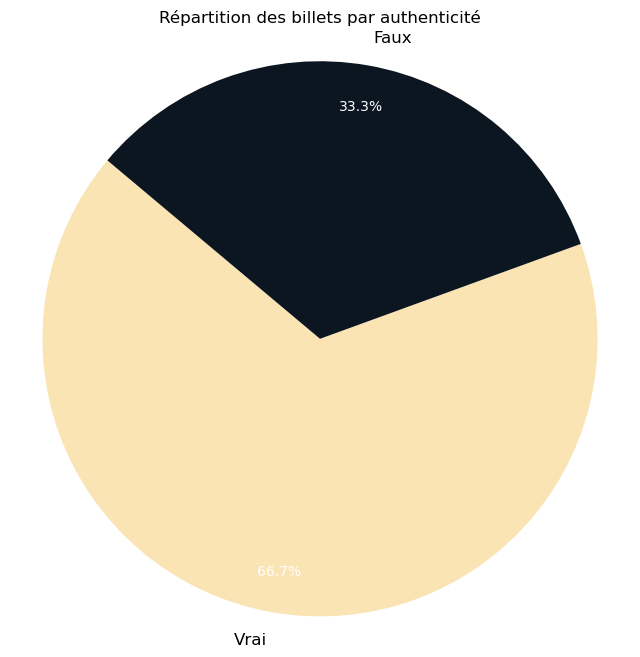

In [8]:
# Compter le nombre de vrais et de faux billets
count_genuine = dfp[dfp["is_genuine"] == 1].shape[0]
count_fake = dfp[dfp["is_genuine"] == 0].shape[0]

# Couleurs inversées des histogrammes
color_genuine = '#fbe4b4'  # Couleur des vrais billets
color_fake = '#0c1621'     # Couleur des faux billets

# Créer le diagramme circulaire
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie([count_genuine, count_fake], labels=["Vrai", "Faux"], startangle=140,
                                   autopct='%1.1f%%', colors=[color_genuine, color_fake], pctdistance=0.85)
for autotext in autotexts:
    autotext.set_color('white')  # Mettre le pourcentage en blanc
plt.setp(texts, size=12)
plt.title('Répartition des billets par authenticité')
plt.axis('equal')  # Rendre le diagramme circulaire équivalent (cercle)
plt.show()

In [9]:
class_counts = dfp['is_genuine'].value_counts()
print(class_counts)

1    1000
0     500
Name: is_genuine, dtype: int64


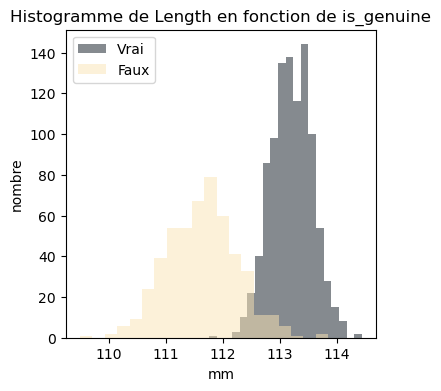

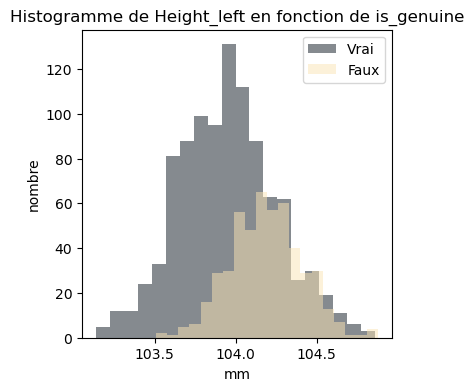

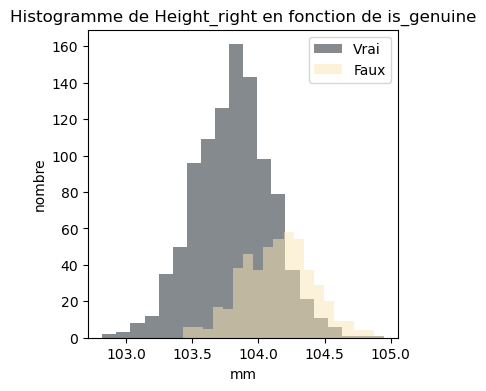

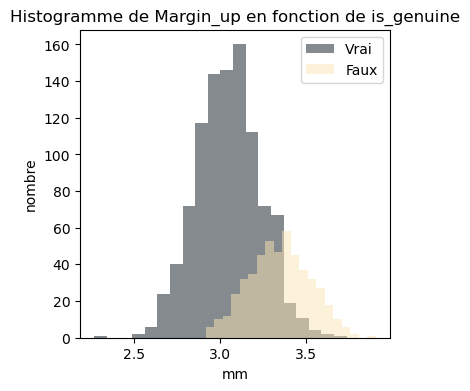

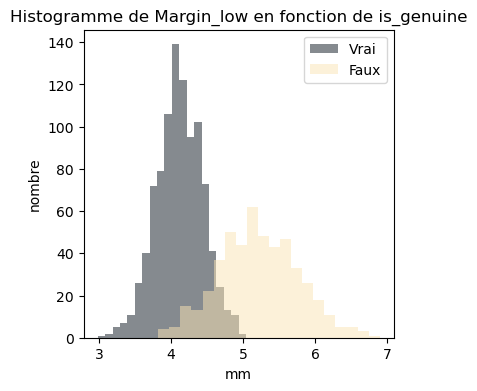

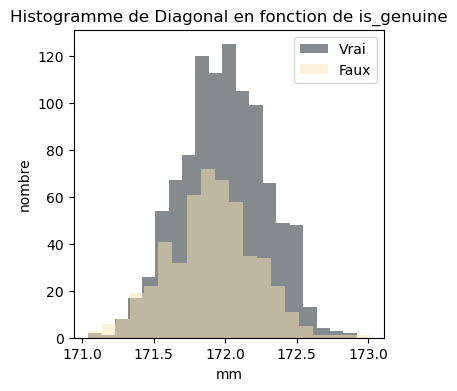

In [10]:
# Séparez les données en fonction de la valeur de is_genuine
genuine_data = dfp[dfp["is_genuine"] == 1]
fake_data = dfp[dfp["is_genuine"] == 0]

# Liste des variables géométriques
variables = ["length", "height_left", "height_right", "margin_up", "margin_low", "diagonal"]

# Créez les histogrammes pour chaque variable
for variable in variables:
    plt.figure(figsize=(4, 4))
    
    # Histogramme pour les vrais billets en bleu
    plt.hist(genuine_data[variable], bins=20, alpha=0.5, color='#0c1621', label='Vrai')
    
    # Histogramme pour les faux billets en or
    plt.hist(fake_data[variable], bins=20, alpha=0.5, color='#fbe4b4', label='Faux')  
    plt.xlabel('mm')
    plt.ylabel('nombre')
    plt.title(f'Histogramme de {variable.capitalize()} en fonction de is_genuine')
    plt.legend()
    
    plt.show()

In [11]:
# Calcul des statistiques pour chaque variable
for variable in variables:
    print(f"Variable : {variable.capitalize()}")
    
    # Statistiques pour les vrais billets
    genuine_stats = genuine_data[variable].describe()
    print("Vrais billets :\n", genuine_stats)
    
    # Statistiques pour les faux billets
    fake_stats = fake_data[variable].describe()
    print("Faux billets :\n", fake_stats)
    
    print("=" * 40)

Variable : Length
Vrais billets :
 count    1000.000000
mean      113.202430
std         0.359552
min       111.760000
25%       112.950000
50%       113.205000
75%       113.460000
max       114.440000
Name: length, dtype: float64
Faux billets :
 count    500.000000
mean     111.630640
std        0.615543
min      109.490000
25%      111.200000
50%      111.630000
75%      112.030000
max      113.850000
Name: length, dtype: float64
Variable : Height_left
Vrais billets :
 count    1000.000000
mean      103.949130
std         0.300231
min       103.140000
25%       103.740000
50%       103.950000
75%       104.140000
max       104.860000
Name: height_left, dtype: float64
Faux billets :
 count    500.000000
mean     104.190340
std        0.223758
min      103.510000
25%      104.040000
50%      104.180000
75%      104.332500
max      104.880000
Name: height_left, dtype: float64
Variable : Height_right
Vrais billets :
 count    1000.00000
mean      103.80865
std         0.29157
min       

## Correlation des variables <a class="anchor" id="cor"></a>

<AxesSubplot:>

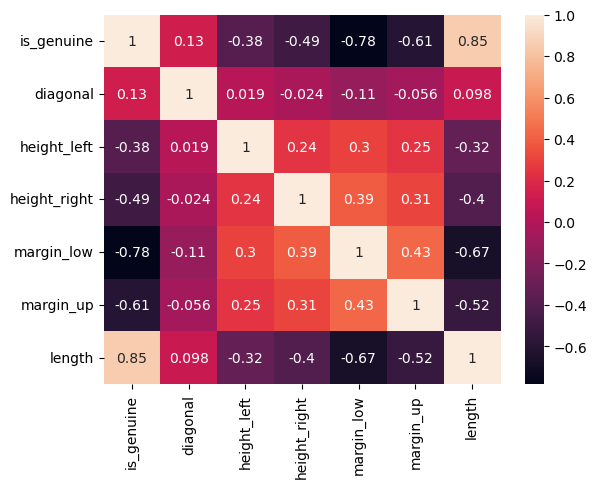

In [12]:
# heatmap de corrélations entre les différentes variables
sns.heatmap(dfp.corr(), annot=True)

<Figure size 100x100 with 0 Axes>

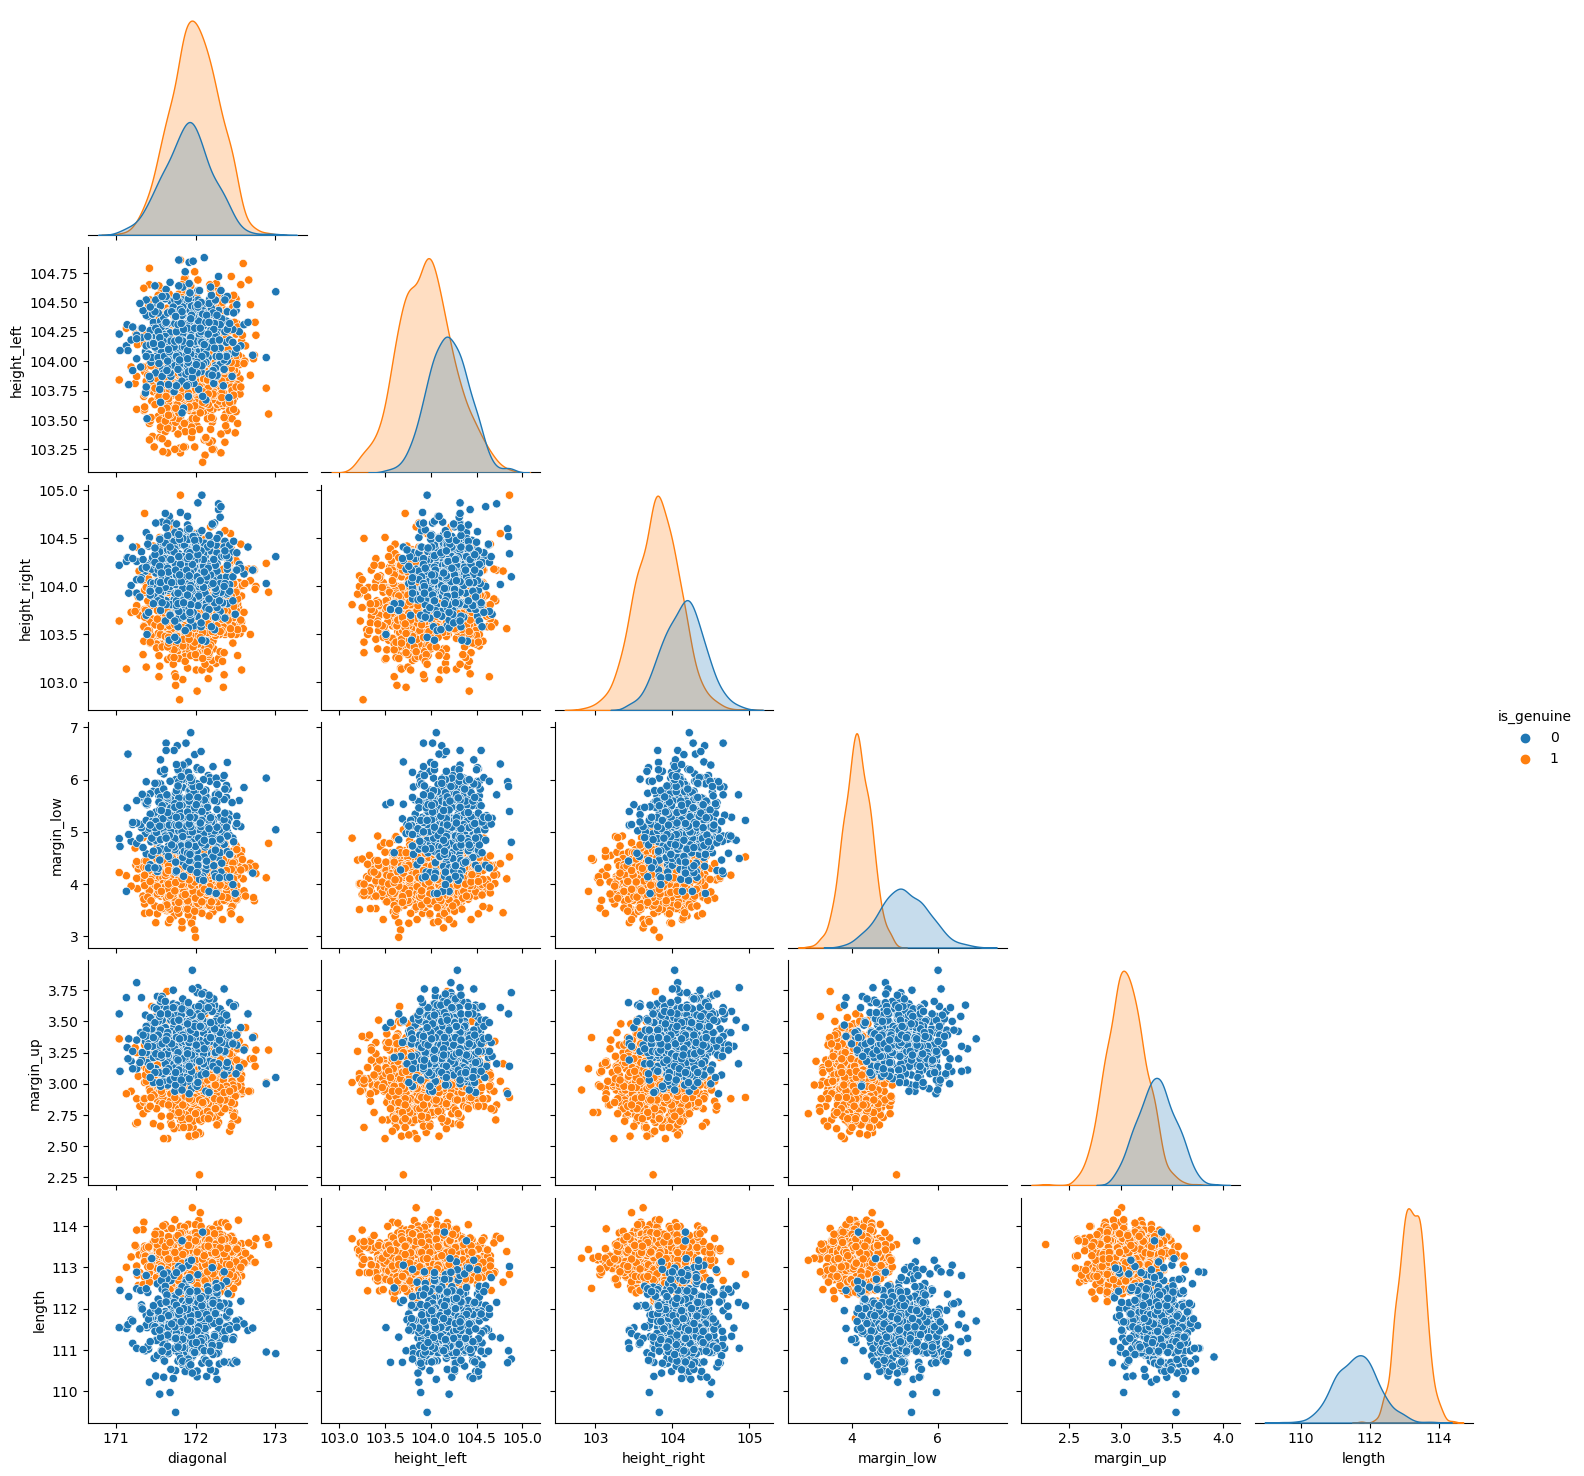

In [13]:
# Couleurs des histogrammes
color_genuine = '#0c1621'  # Couleur des vrais billets
color_fake = '#fbe4b4'     # Couleur des faux billets

# Mapper les couleurs en fonction de la colonne "is_genuine"
color_map = {1: color_genuine, 0: color_fake}
colors_by_is_genuine = dfp["is_genuine"].map(color_map)
plt.figure(figsize=(1, 1))
sns.pairplot(dfp,hue='is_genuine',corner=True)

# Régression linéaire <a class="anchor" id="reglin"></a>

Nous allons utiliser un modèle de régression linéaire multivariables pour traiter nos valeurs manquantes  
Pour cela, nous allons séparer le DataFrame en 2:  
* un dataframe sans les valeurs manquantes pour la régression linéaire  
* un dataframe avec seulement les valeurs manquantes

In [14]:
data_missing = dfp[dfp['margin_low'].isnull()]
data_not_missing = dfp[~dfp['margin_low'].isnull()]

X = data_not_missing[['length', 'height_left', 'height_right', 'margin_up', 'diagonal', 'is_genuine']]
y = data_not_missing['margin_low']

X = sm.add_constant(X)  # Ajoute une colonne constante pour l'interception

model = sm.OLS(y, X).fit()  # Ajuste le modèle

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     390.7
Date:                Sun, 27 Aug 2023   Prob (F-statistic):          4.75e-299
Time:                        21:58:38   Log-Likelihood:                -774.14
No. Observations:                1463   AIC:                             1562.
Df Residuals:                    1456   BIC:                             1599.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.8668      8.316      0.345   

On constate ici que certains paramètres ne sont pas significativement différents de 0, car leur p-valeur n'est pas inférieure à 5 %, le niveau de test que nous souhaitons.

Le  𝑅² aut environ 0.617, et le  𝑅²  ajusté est d'environ 0.615.

On va donc maintenant retirer les variables non significatives.

In [15]:
X = data_not_missing[['margin_up', 'is_genuine']]
y = data_not_missing['margin_low']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

X_missing = data_missing[['margin_up', 'is_genuine']]
X_missing = sm.add_constant(X_missing)

predicted_missing = model.predict(X_missing)
dfp.loc[dfp['margin_low'].isnull(), 'margin_low'] = predicted_missing

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                Sun, 27 Aug 2023   Prob (F-statistic):          1.24e-304
Time:                        21:58:38   Log-Likelihood:                -774.73
No. Observations:                1463   AIC:                             1555.
Df Residuals:                    1460   BIC:                             1571.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.9263      0.198     30.003      0.0

In [16]:
print(dfp['margin_low'].isnull().sum())

0


## Calculez les leviers <a class="anchor" id="lev"></a>

C:\Users\GUIGUI\AppData\Local\Temp\ipykernel_25420\1052863011.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_not_missing['leverage'] = leverage


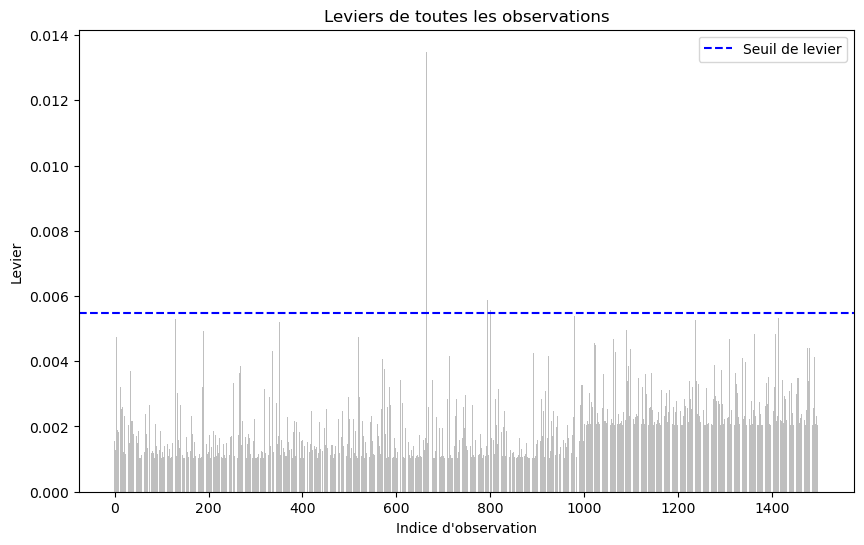

Observations potentiellement aberrantes basées sur les leviers :
      is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
48             1    172.07       104.05        103.82        3.71       3.61   
52             1    171.64       104.18        103.78        3.49       3.74   
125            1    171.50       104.03        103.97        3.26       3.54   
384            1    171.65       103.50        103.24        3.82       2.56   
664            1    172.05       103.70        103.75        5.04       2.27   
670            1    172.27       104.29        104.22        3.89       3.53   
794            1    171.88       103.84        103.87        4.18       3.54   
800            1    171.96       104.09        103.67        3.75       2.58   
980            1    172.12       104.08        104.49        4.09       3.56   
1029           0    171.96       104.29        104.03        6.01       3.91   
1199           0    172.03       104.32        104.87  

In [17]:
# Calcul des leviers
leverage = model.get_influence().hat_matrix_diag

# Ajout des leviers au DataFrame
data_not_missing['leverage'] = leverage

# Seuil pour identifier les observations aberrantes
seuil_leverage = 2 * (X.shape[1] + 1) / X.shape[0]  # Seuil recommandé : (2 * (nombre de prédicteurs + 1)) / taille de l'échantillon

# Identifier les observations aberrantes en fonction du seuil de levier
outliers_leverage = data_not_missing[data_not_missing['leverage'] > seuil_leverage]

# Affichage des leviers de toutes les observations
plt.figure(figsize=(10, 6))
plt.bar(data_not_missing.index, data_not_missing['leverage'], color='gray', alpha=0.5)
plt.axhline(y=seuil_leverage, color='blue', linestyle='--', label='Seuil de levier')
plt.xlabel('Indice d\'observation')
plt.ylabel('Levier')
plt.title('Leviers de toutes les observations')
plt.legend()
plt.show()

print("Observations potentiellement aberrantes basées sur les leviers :")
print(outliers_leverage)

67 levier sont au dessus du seuil

## Calculez les residus studentisé <a class="anchor" id="res"></a>

C:\Users\GUIGUI\AppData\Local\Temp\ipykernel_25420\1686185013.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_not_missing['studentized_residuals'] = studentized_residuals


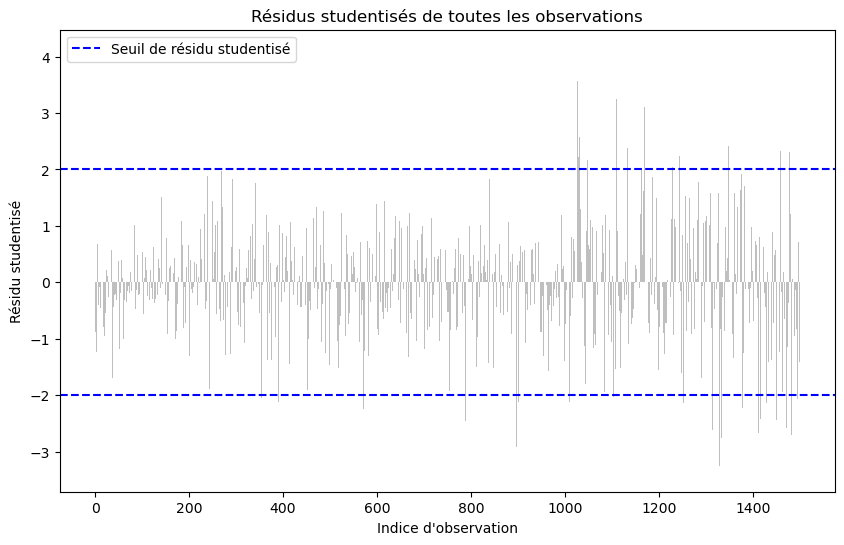

Nombre d'observations avec des résidus extrêmes : 75


In [18]:
# Calcul des résidus studentisés
studentized_residuals = model.get_influence().resid_studentized_internal

# Ajout des résidus studentisés au DataFrame
data_not_missing['studentized_residuals'] = studentized_residuals

# Affichage des résidus studentisés de toutes les observations
plt.figure(figsize=(10, 6))
plt.bar(data_not_missing.index, data_not_missing['studentized_residuals'], color='gray', alpha=0.5)
plt.axhline(y=2, color='blue', linestyle='--', label='Seuil de résidu studentisé')
plt.axhline(y=-2, color='blue', linestyle='--')
plt.xlabel('Indice d\'observation')
plt.ylabel('Résidu studentisé')
plt.title('Résidus studentisés de toutes les observations')
plt.legend()
plt.show()

# Calcul du nombre d'observations avec des résidus extrêmes
upper_threshold = 2  # Seuil supérieur
lower_threshold = -2  # Seuil inférieur
num_extreme_residuals = ((data_not_missing['studentized_residuals'] > upper_threshold) |
                         (data_not_missing['studentized_residuals'] < lower_threshold)).sum()

print(f"Nombre d'observations avec des résidus extrêmes : {num_extreme_residuals}")

## Distance de cook <a class="anchor" id="cook"></a>

C:\Users\GUIGUI\AppData\Local\Temp\ipykernel_25420\2618975390.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_not_missing['cooks_distance'] = cooks_distance
C:\Users\GUIGUI\AppData\Local\Temp\ipykernel_25420\2618975390.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_not_missing['cooks_distance'] = cooks_distance


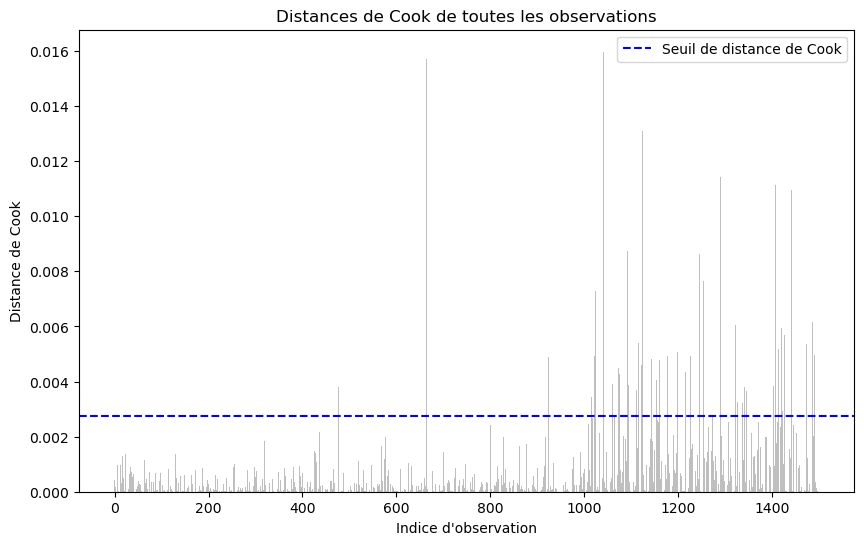

Nombre d'observations avec des distances de Cook supérieures au seuil : 102


In [19]:
# Calcul de la distance de Cook
cooks_distance, _ = model.get_influence().cooks_distance

# Ajout de la distance de Cook au DataFrame
data_not_missing['cooks_distance'] = cooks_distance

# Seuil pour identifier les observations influentes
seuil_cook = 4 / len(data_not_missing)  # Seuil recommandé : 4 / nombre d'observations

# Ajout de la distance de Cook au DataFrame
data_not_missing['cooks_distance'] = cooks_distance

# Affichage des distances de Cook de toutes les observations
plt.figure(figsize=(10, 6))
plt.bar(data_not_missing.index, data_not_missing['cooks_distance'], color='gray', alpha=0.5)
plt.axhline(y=seuil_cook, color='blue', linestyle='--', label='Seuil de distance de Cook')
plt.xlabel('Indice d\'observation')
plt.ylabel('Distance de Cook')
plt.title('Distances de Cook de toutes les observations')
plt.legend()
plt.show()

# Calcul du nombre d'observations avec des distances de Cook supérieures au seuil
num_observations_above_threshold = (data_not_missing['cooks_distance'] > seuil_cook).sum()

print(f"Nombre d'observations avec des distances de Cook supérieures au seuil : {num_observations_above_threshold}")

### Vérification des hypothèses <a class="anchor" id="hyp"></a>

Pour valider l'utilisation de la régression linéaire, il y a plusieurs hypothèses a vérifier :  

* **Normalité** : Les erreurs résiduelles doivent être distribuées normalement. Cela signifie que les résidus doivent suivre une distribution normale avec une moyenne de zéro.
* **Homoscédasticité** : La variance des erreurs résiduelles doivent être constante à tout les niveaux de la variable prédictive.
* **Multicolinéarité** : C'est la relation entre les variables prédictives. Elle ne devrais pas avoir de forte corrélation linéaire entre les variables indépendantes.

#### Hypothèse de la normalité des résidus

Test de shapiro-Wilk

In [20]:
from scipy import stats

residuals = model.resid

shapiro_test = stats.shapiro(residuals)
print("Statistique de test:", shapiro_test.statistic)
print("Valeur p:", shapiro_test.pvalue)

if shapiro_test.pvalue > 0.05:
    print("Les résidus semblent suivre une distribution normale.")
else:
    print("Les résidus ne suivent pas une distribution normale.")

Statistique de test: 0.9936248064041138
Valeur p: 6.20942773821298e-06
Les résidus ne suivent pas une distribution normale.


Ici, l'hypothèse de normalité est remise en cause (p-value = 7.05e-06 < 0.05).

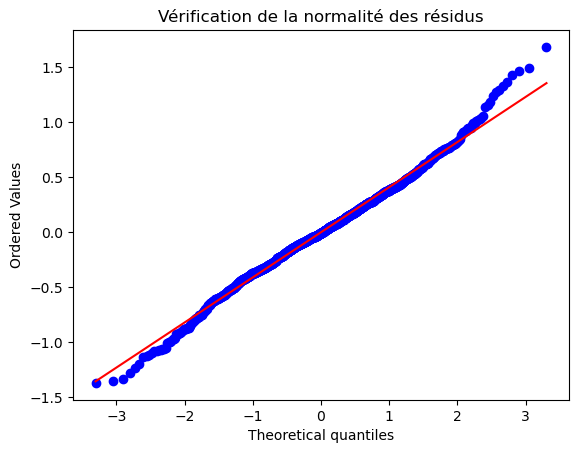

In [21]:
# Vérification de la normalité des résidus avec un Q-Q plot
residuals = model.resid
stats.probplot(residuals, plot=plt)
plt.title("Vérification de la normalité des résidus")
plt.show()

Dans ce code, le graphique Q-Q plot (probabilité normale-quantile) compare les quantiles des résidus à ceux d'une distribution normale. Si les points sur le graphique suivent approximativement la ligne diagonale, cela indique que les résidus suivent une distribution normale.

#### homoscédasticité

 Les résidus doivent avoir une variance constante (homoscédasticité) à travers toutes les valeurs prédites.

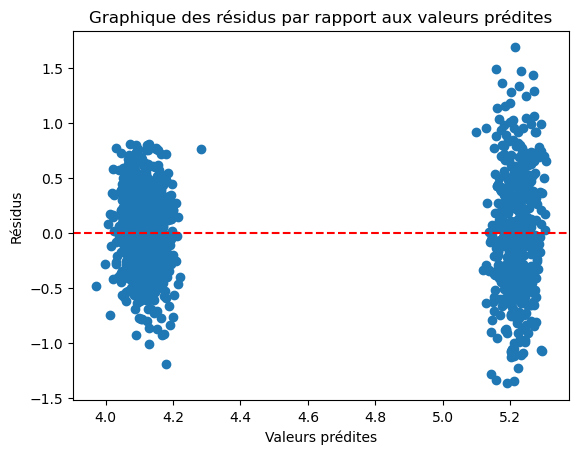

In [22]:
plt.scatter(model.fittedvalues, residuals)
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.title("Graphique des résidus par rapport aux valeurs prédites")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

le graphique des résidus par rapport aux valeurs prédites nous permets de visualiser si la dispersion des résidus reste constante le long de la ligne horizontale (indiquant l'homoscédasticité).
Dans notre cas, il n'y a pas d'homoscédasticité

#### Vérifier la colinéarité des variables

Pour vérifier l'absence de colinéarité entre les variables indépendantes dans une régression linéaire, nous allons calculer les facteurs d'inflation de la variance (VIF) pour chaque variable. Les VIF élevés indiquent une forte corrélation entre une variable et les autres variables indépendantes

In [23]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = data_not_missing[['margin_up', 'is_genuine']]

vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

     Variable       VIF
0   margin_up  2.622757
1  is_genuine  2.622757


les facteurs d'inflation de la variance (VIF) sont calculés pour chaque variable indépendante. Si un VIF dépasse 10 il y a colinéarité, cela indique donc qu'il n'y a pas de colinéarité

# Application du modèle <a class="anchor" id="appli"></a>

In [24]:
df_final =dfp.copy()

In [25]:
# vérification des valeurs nulles
df_final.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

<AxesSubplot:ylabel='margin_low'>

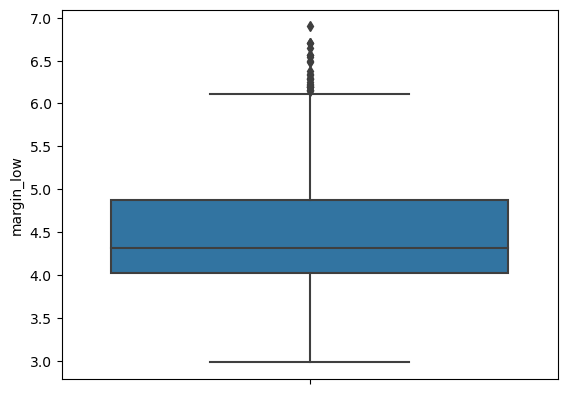

In [26]:
sns.boxplot(data=df_final,y='margin_low')

## Régression logistique <a class="anchor" id="log"></a>

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pickle

# Sélection des variables pour la régression logistique
X_logistic = df_final.drop(['is_genuine'], axis=1)  # Toutes les variables sauf la cible et les colonnes ajoutées
y_logistic = df_final['is_genuine']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_logistic, y_logistic, test_size=0.2, random_state=42)

# Ajout de la constante pour la régression logistique
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Régression Logistique avec statsmodels
logistic_model = sm.Logit(y_train, X_train).fit()

print(logistic_model.summary())


Optimization terminated successfully.
         Current function value: 0.028458
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1200
Model:                          Logit   Df Residuals:                     1193
Method:                           MLE   Df Model:                            6
Date:                Sun, 27 Aug 2023   Pseudo R-squ.:                  0.9549
Time:                        21:58:45   Log-Likelihood:                -34.149
converged:                       True   LL-Null:                       -756.70
Covariance Type:            nonrobust   LLR p-value:                4.162e-309
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -93.5468    263.799     -0.355      0.723    -610.584     423.490
diagonal        -0.288

On constate ici que certains paramètres ne sont pas significativement différents de 0, car leur p-valeur n'est pas inférieure à 5 %, le niveau de test que nous souhaitons.

Le 𝑅2²  ajusté est d'environ 0.9548.

On va donc maintenant retirer les variables non significatives.

47 % des billets peuvent être prédit parfaitement.

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pickle

# Sélection des variables pour la régression logistique
X_logistic = df_final.drop(['is_genuine', 'height_left', 'diagonal'], axis=1)
y_logistic = df_final['is_genuine']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_logistic, y_logistic, test_size=0.2, random_state=42)

# Ajout de la constante pour la régression logistique
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Régression Logistique avec statsmodels
logistic_model = sm.Logit(y_train, X_train).fit()
print(logistic_model.summary())


Optimization terminated successfully.
         Current function value: 0.028983
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1200
Model:                          Logit   Df Residuals:                     1195
Method:                           MLE   Df Model:                            4
Date:                Sun, 27 Aug 2023   Pseudo R-squ.:                  0.9540
Time:                        21:58:45   Log-Likelihood:                -34.780
converged:                       True   LL-Null:                       -756.70
Covariance Type:            nonrobust   LLR p-value:                2.159e-311
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -249.7828    151.710     -1.646      0.100    -547.129      47.563
height_right    -3.294

## Test d'hypothèse <a class="anchor" id="hyp2"></a>

* **La variable de réponse est binaire/quali** : Is_genuine est bien binaire (oui/non) 

* **La taille de l'échantillon doit être suffisante**: En règle générale, on souhaite avoir plus de 500 observations indépendantes et plus de 20 observations pour l'outcome la moins fréquente. C'est le cas ici puisque nous avons 1500 observations dont 500 faux billets.

* **Les observations sont indépendantes** : Ici nos billets sont uniques et indépendants des autres

* **Test de multicolinéarité** :

In [29]:
# Calcul des VIF pour chaque variable dans X_train (sans la constante)
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns[1:]  # Exclure la constante
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i+1) for i in range(X_train.shape[1]-1)]

print(vif_data)

        feature       VIF
0  height_right  1.239585
1    margin_low  1.890715
2     margin_up  1.413881
3        length  2.191049


Aucune variable > 5. Il n'y a donc pas de coliinéarité

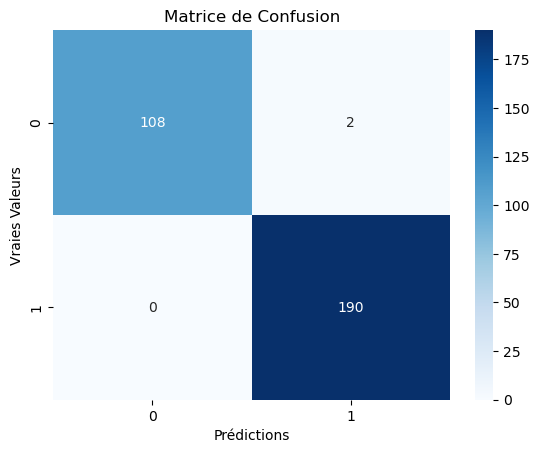

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       110
           1       0.99      1.00      0.99       190

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



In [30]:
# Prédictions sur le jeu de test
y_pred = logistic_model.predict(X_test)
y_pred_binary = (y_pred >= 0.5).astype(int)

# Matrice de Confusion en Heatmap
conf_matrix = confusion_matrix(y_test, y_pred_binary)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédictions')
plt.ylabel('Vraies Valeurs')
plt.title('Matrice de Confusion')
plt.show()

# Rapport de Classification
print(classification_report(y_test, y_pred_binary))

Notre modèle est quasiment parfait, tout les scores approchent 1. 

Accuracy :(précision) ration de prédiction juste.

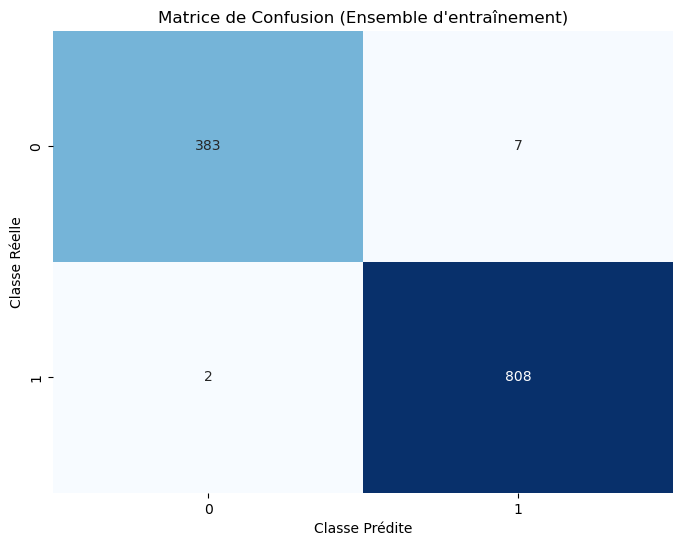

In [31]:
# Prédiction des classes sur l'ensemble d'entraînement
y_train_pred = logistic_model.predict(X_train)
y_train_pred_class = (y_train_pred > 0.5).astype(int)

# Création de la matrice de confusion pour l'ensemble d'entraînement
confusion_train = confusion_matrix(y_train, y_train_pred_class)

# Création d'un heatmap pour la matrice de confusion de l'ensemble d'entraînement
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_train, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Classe Prédite')
plt.ylabel('Classe Réelle')
plt.title('Matrice de Confusion (Ensemble d\'entraînement)')
plt.show()

In [32]:
df_final['predicted_class'] = logistic_model.predict(sm.add_constant(X_logistic)) >= 0.5
df_final['predicted_probability'] = logistic_model.predict(sm.add_constant(X_logistic))

# Calculer et ajuster les probabilités pour les billets faux
df_final['predicted_probability'] = df_final.apply(lambda row: 1 - row['predicted_probability'] if not row['predicted_class'] else row['predicted_probability'], axis=1)

# Arrondir les valeurs de pourcentage à 2 décimales
df_final['predicted_probability'] = df_final['predicted_probability'].apply(lambda x: round(x, 5))

# Afficher le DataFrame avec les nouvelles colonnes
print(df_final)

      is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0              1    171.81       104.86        104.95        4.52       2.89   
1              1    171.46       103.36        103.66        3.77       2.99   
2              1    172.69       104.48        103.50        4.40       2.94   
3              1    171.36       103.91        103.94        3.62       3.01   
4              1    171.73       104.28        103.46        4.04       3.48   
...          ...       ...          ...           ...         ...        ...   
1495           0    171.75       104.38        104.17        4.42       3.09   
1496           0    172.19       104.63        104.44        5.27       3.37   
1497           0    171.80       104.01        104.12        5.51       3.36   
1498           0    172.06       104.28        104.06        5.17       3.46   
1499           0    171.47       104.15        103.82        4.63       3.37   

      length  predicted_class  predicte

In [33]:
with open('logistic_model.pkl', 'wb') as model_file:
    pickle.dump(logistic_model, model_file)

# K-means <a class="anchor" id="kmeans"></a>

Avec le model du coude, nous pouvons voir que le nombre de cluster optimal serrait de 2

C:\Users\GUIGUI\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


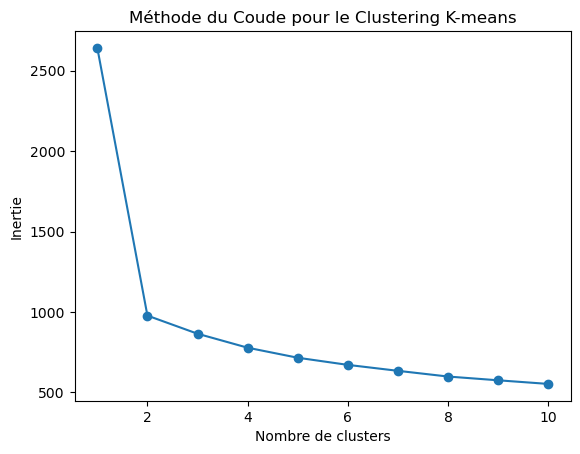

In [34]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Sélection des variables pour le clustering K-means
X_kmeans = df_final.drop(['is_genuine'], axis=1)

# Trouver le nombre optimal de clusters en utilisant la méthode du coude
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_kmeans)
    inertia.append(kmeans.inertia_)

# Tracer le graphique du coude
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title('Méthode du Coude pour le Clustering K-means')
plt.show()

In [35]:
# Utilisation du nombre optimal de clusters (par exemple, 3 clusters)
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_final['cluster'] = kmeans.fit_predict(X_kmeans)


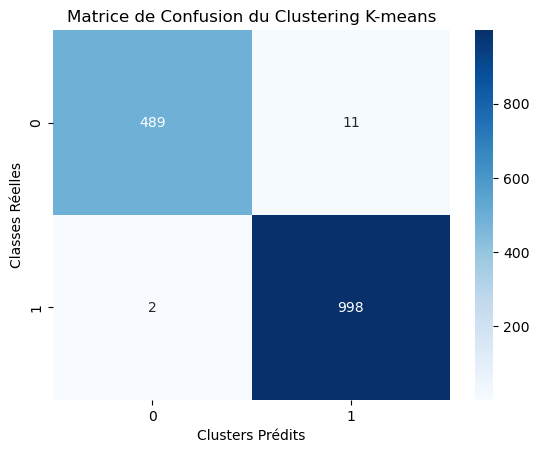

Score du modèle K-means: 0.9913333333333333


In [36]:
from sklearn.metrics import confusion_matrix

# Création de la matrice de confusion
conf_matrix_kmeans = confusion_matrix(df_final['is_genuine'], df_final['cluster'])

# Affichage de la matrice de confusion en heatmap
sns.heatmap(conf_matrix_kmeans, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Clusters Prédits')
plt.ylabel('Classes Réelles')
plt.title('Matrice de Confusion du Clustering K-means')
plt.show()

# Calcul du score du modèle K-means
accuracy_kmeans = sum(df_final['is_genuine'] == df_final['cluster']) / len(df_final)
print("Score du modèle K-means:", accuracy_kmeans)


# Conclusion  <a class="anchor" id="con"></a>

99% pour la regression logistique  
99% pour le Kmeans

Je choisirais donc de prendre la regression linéaire pour analyser les billets en fonction de mes matrices de confusion.